## Предсказание будущих реакций на основе предшествующих

In [1]:
%pylab inline
import matplotlib.animation as animation
import pandas as pd
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [2]:
rc('animation', html='html5')
# rcParams

In [3]:
#загрузка данных
u='http://balatte.stireac.com/result.tsv/sherdim%40gmail.com/tuts__2143043410150713'
D = pd.read_csv(u, delimiter='\t')
D.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
t    48 non-null float64
v    46 non-null float64
dtypes: float64(2)
memory usage: 848.0 bytes


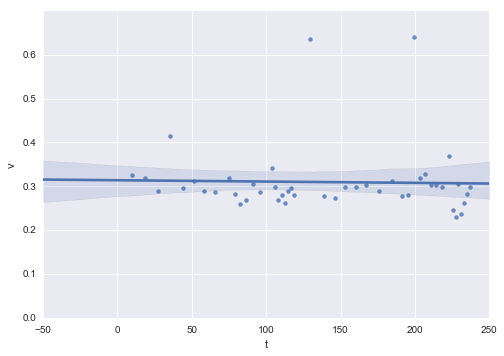

In [4]:
sns.regplot('t','v',data=D); ylim(0);

Представим, что мы хотим предсказывать время реакции (ВР) непосредственно в ходе эксперимента. Другими словами мы хотим делать прогноз в режиме "реального времени".

Для упрощения представим, что мы ничего не знаем о заданном порядке МСИ и о модальности стимула.

В нулевой момент времени у нас нет данных. Мы прогнозируем, что ВР будет как у большинства людей от 150 до 350 мс. Возмем среднее значение 0.25 с.

In [5]:
# заполним всю колонку этим значением
D['prognoz'] = 0.25
D.head()

,t,v,prognoz
0,9.582,0.325,0.25
1,18.642,0.320,0.25
2,27.249,0.289,0.25
3,35.363,0.415,0.25
4,43.745,0.296,0.25


Первые 9 секунд нашего эксперимента у нас все еще нет данных, и мы не можем оценить качество нашего прогноза. Как только появляются данные - мы можем рассчитать отклонение - среднеквадратичное.
(root-mean-square error (RMSE))

In [6]:
sqrt(mean((D.v[0] - D.prognoz[0])**2))

0.075000000000000011

В случае одного значения это все равно что абсолютное значение разности между прогнозируемым и реальным значениями.

Если значений много, то все равно будет одно число. Это число - метрика качества нашего прогноза, на основании которой мы можем сравнивать разные алгоритмы.

Есть несколько принципов прогноза:
1. Если что-то происходит сейчас так, то и в будущем будет так же.
2. Если есть четкая тенденция, то она продолжится.
3. Текущее значение может быть артефактом, т.е. возникло в результате случайного непредвиденного воздействия, которое больше может не повториться
4. Чем больше данных в прошлом, тем лучше можно сделать прогноз будущего

Мы попробуем сделать несколько логических шагов для понимания сути однонаправленного моделирования. Более зрелые модели доступны в специальных пакетах, на которые будут ссылки в конце.

In [32]:
#сохраним текущий прогноз как первый вариант подхода "среднее по больнице"
D['pro_populatio']=D['prognoz']

#зададим функцию для удобства оценки качества прогноза
def quo(k):
    '''чем больше отклонение - тем ниже эффективность'''
    return 1/sqrt(mean((D.v - D[k])**2))
quo('pro_populatio')

8.9588907242925249

Итого, если прогноз делать с потолка, то есть считать, что как у всех в среднем, то его эффективность 10 попугаев.

Возьмем на вооружение первый принцип. Будем ждать каждый раз повторения последнего значения.

In [9]:
D.prognoz[1:]= D.v[:-1]
D.prognoz.fillna(method='ffill', inplace=True) #при пропусках оставляем предыдущий
D['pro_prev'] = D['prognoz']
quo('pro_prev')

8.9588907242925249

Удивительно, но прогноз оказался хуже. Потому что постоянные 0.25 не так далеко от большинства значений в районе 0.3, а вот при прогнозе по предыдущему отдельные выбросы более 0.6 сделали свое черное дело: прогноз после них был крайне неудачным. 

In [11]:
def play_prognoz(k='prognoz', n_future = 1, k0='v', interval=500):

    xx=D.index.values
    tt= xx[:-1]

    fig = figure()
    xlim(0,len(D.index)+1); ylim(0,0.7);

    hh=[]
    hh.append( plot([],[], color='b', lw=0, marker='d')[0] )
    hh.append( plot(xx[0],D[k][0], color='r', marker='*')[0] ) #prognoz
    hh.append( vlines([],[],[], colors='pink') ) #residuals

    def updatefig(i):
        hh[0].set_data(xx[:i+1], D[k0][:i+1])
        hh[1].set_data(xx[[i,i+n_future]], D[k][[i,i+1]])
        res1=vstack([tile(xx[i],(2,)), [D.ix[i,k0],D.ix[i,k]]]).T
        hh[2].set_segments((hh[2].get_segments() + [res1]))
                            
        return hh

    close()
    ani = animation.FuncAnimation(fig, updatefig, tt, interval=interval, blit=True, repeat=False)
    return ani

play_prognoz('pro_prev')

Из-за выбросов становится понятно, что полагаться только на последнее значение опрометчиво. Лучше использовать для прогноза несколько последних значений.

Для ослабления влияния выбросов в качестве оценке центральной тенденции лучше использовать медиану.

In [29]:
D['pro_median5']=D.v.rolling(5,  min_periods=1).median()
play_prognoz('pro_median5')

Сравним эффективность предсказания по медиане с предсказанием по среднему.

In [31]:
D['pro_mean5']=D.v.rolling(5,  min_periods=1).mean()
quo('pro_median5'), quo('pro_mean5')

(12.973071526995152, 14.433100611266378)

В данном случае среднее ведет себя лучше - 14 попугаев.

И среднее, и медиана являются способами оценить центральную тенденцию (*[M-estimator](https://en.wikipedia.org/wiki/M-estimator)*)


Вместо усреднения можно ввести взвешенное среднее, чтобы более экстремальные значения вносили меньший вклад, чем более типичные близкие к среднему. На практике используются разные [весовые функции]( http://statsmodels.sourceforge.net/stable/rlm_techn1.html).

Например, после первых 5 значений мы хотели бы иметь прогноз в районе 0.3, т.е. ослабить влияние 4-го значения, превышающего 0.4.

In [48]:
x=D.v[:5]
z=((x - x.mean())/x.std()).values
z

array([-0.07928179, -0.17838402, -0.79281789,  1.70455846, -0.65407476])

In [67]:
wRamsay = exp(-0.3*abs(z))  #Ramsay’s Ea
wRamsay = wRamsay/sum(wRamsay)

t=1.345;  wHuber = [(t/_z if _z>t else 1.) for _z in abs(z)]
wHuber = wHuber/sum(wHuber)

mean(x), sum(x*0.2), sum(x*wRamsay), sum(x*wHuber)

(0.329, 0.329, 0.32427883527202994, 0.32521203702094353)

Мы берем 5 последних значений, значит средний возраст данных для прогноза - 3 временных шага. Получается, что если в серии происходят изменения - мы постоянно запаздываем в среднем на 3 шага назад.

Попробуем реализовать еще один принцип - недавние события имеют большую предсказательную силу, чем предыдущие. Для этого наделим большим весом последнее значение, а предыдущие - постепенно убывающими весами. Популярное решение - *простое экспоненциальное сглаживание* (simple exponential smoothing (SES)) или exponentially weighted moving average (EWMA).

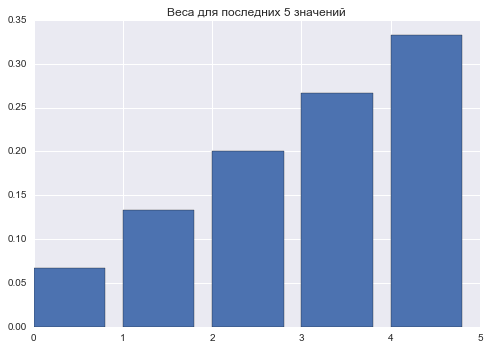

In [100]:
# weighted moving average (WMA)
w=(arange(5)+1)
w=w/w.sum()
bar(arange(5), w);
title('Веса для последних 5 значений');

In [86]:
rol = D.v.fillna(method='ffill').rolling(5)

D['pro_wma']=rol.apply(lambda x: sum(x*w[-len(x):]))
quo('pro_wma')

16.481338714885133

In [87]:
play_prognoz('pro_wma')

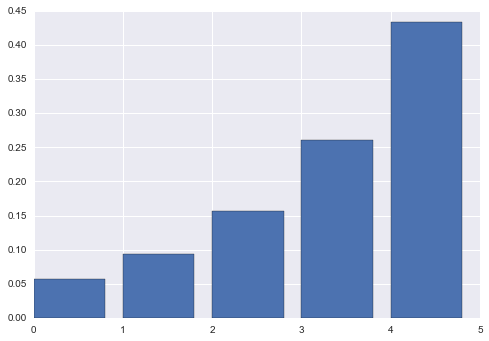

In [113]:
# exponentially weighted moving average (EWMA)
alpha = 0.4
# (1 − α)2
w=alpha*((1-alpha)**arange(5,0,-1))
w=w/w.sum()
bar(arange(5), w);

In [98]:
rol = D.v.fillna(method='ffill').rolling(5)

D['pro_ewma']=rol.apply(lambda x: sum(x*w[-len(x):]))
quo('pro_ewma')

19.171712832354412

In [99]:
play_prognoz('pro_ewma')

Используя экпоненциально взвешенную среднюю мы получили качество в 19 попугаев. Однако нам все еще мешают выбросы. Попробуем объединить веса, ослабляющие экстремальные значения, с весами, ослабляющими старые значения. Это так называемая *конволюция*.

In [116]:
def _conv1(x, alpha = 0.5):
    wEWMA=alpha*((1-alpha)**arange(5,0,-1))
    z=((x - x.mean())/x.std())
    w = exp(-0.3*abs(z))  #Ramsay’s Ea
    w=w*wEWMA
    w = w/sum(w)
    return sum(x*w)

_conv1(x)

0.32197314372519376

In [117]:
D['pro_conv1']=rol.apply(_conv1)
quo('pro_conv1')

19.856168151970881

In [119]:
def _conv2(x, alpha = 0.5, t=1.345):
    wEWMA=alpha*((1-alpha)**arange(5,0,-1))
    z=((x - x.mean())/x.std())
    w = [(t/_z if _z>t else 1.) for _z in abs(z)]
    w=w*wEWMA
    w = w/sum(w)
    return sum(x*w)

_conv2(x)

0.32329846106558197

In [120]:
D['pro_conv2']=rol.apply(_conv2)
quo('pro_conv2')

20.155630665340965

In [121]:
play_prognoz('pro_conv2')

Если мы уверены, что величина выброса не имеет значения, то можем загнать данные в заданные рамки. Это позволит более адекватно оценивать модели. Просто удалить выбросы при моделировании динамики нежелательно, поскольку мы нарушим ход времени. Замена на пустые значения также снизит информативность.

Например, в данном случае что 0.4, что 0.65 с характеризуют поздние реакции при пропуске стимула. Мы можем задать границу 0.4, чтобы все поздние реакции отклонялись в большую сторону, но при этом не так влияли на среднее значение. Такой прием, автоматически загоняющий выбросы в пределы заданных перцентилей, называется *винсоризацией*.

In [130]:
import scipy.stats.mstats

D['vwin']=scipy.stats.mstats.winsorize(D.v, 0.1)
D.vwin.describe()

count    48.000000
mean      0.306146
std       0.043590
min       0.261000
25%       0.279000
50%       0.297000
75%       0.314250
max       0.415000
Name: vwin, dtype: float64

In [131]:
D['prowin_conv2']=D.vwin.fillna(method='ffill').rolling(5).apply(_conv2)
def quowin(k):
    return 1/sqrt(mean((D.vwin - D[k])**2))
quo('prowin_conv2')

14.822949186163703

In [133]:
play_prognoz('prowin_conv2', k0='vwin')

Можно попробовать еще более продвинутые методы расчета весовых коэффициентов для подбора лучшего предсказания по группе последних значений, например [IRLS](https://en.wikipedia.org/wiki/Iteratively_reweighted_least_squares) с [функцией потерь Хубера](https://en.wikipedia.org/wiki/Huber_loss) или разные варианты ARIMA.

Кроме линейной можно попробовать сплайновую интерполяцию - `scipy.interpolate.spline`

### +++:

[Embedding Matplotlib Animations in Jupyter Notebooks](http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/)

[ImageMagick](https://www.imagemagick.org/script/download.php#windows) - утилиты для конвертации видео. Устанавливают `FFMpeg` автоматически. Можно [вручную](http://adaptivesamples.com/how-to-install-ffmpeg-on-windows/).

[Moving average and exponential smoothing models](https://people.duke.edu/~rnau/411avg.htm)